In [1]:
import sys
import importlib
from dataclasses import replace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.vector_ar.vecm import coint_johansen

project_root = Path.cwd()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pairs_trading_etf.analysis.correlation as correlation_module
correlation_module = importlib.reload(correlation_module)

from pairs_trading_etf.analysis.correlation import (
    attach_sector_labels,
    compute_return_correlations,
    find_high_corr_pairs,
    plot_corr_vs_pvalue,
    plot_correlation_clustermap,
    plot_correlation_heatmap,
    plot_pair_bucket_boxplot,
    plot_pair_bucket_counts,
    summarise_pairs_by_bucket,
 )
from pairs_trading_etf.data.loader import build_price_frame
from pairs_trading_etf.data.universe import load_configured_universe
from pairs_trading_etf.pipelines.pair_scan import PairScanConfig, run_pair_scan
from pairs_trading_etf.utils.config import load_yaml_config

sns.set_theme(style="white", context="talk")

CONFIG_PATH = project_root / "configs" / "data.yaml"
PRICE_PATH = project_root / "data" / "raw" / "etf_prices.csv"
METADATA_PATH = project_root / "configs" / "etf_metadata.yaml"
RESULTS_PATH = project_root / "results" / "week1_pair_scores.csv"
FIGURES_DIR = project_root / "results" / "figures" / "week1"
JOHANSEN_PATH = project_root / "results" / "week1_johansen_trace.csv"
HEATMAP_PATH = FIGURES_DIR / "week1_corr_heatmap.png"
CLUSTER_PATH = FIGURES_DIR / "week1_corr_clustermap.png"
PAIR_COUNTS_PATH = FIGURES_DIR / "week1_pair_bucket_counts.png"
PAIR_BOX_PATH = FIGURES_DIR / "week1_pair_corr_box.png"
SCATTER_PATH = FIGURES_DIR / "week1_corr_vs_pvalue.png"
HIGH_CORR_PATH = project_root / "results" / "week1_high_corr_pairs.csv"

CONFIG_PATH, PRICE_PATH, METADATA_PATH, RESULTS_PATH, FIGURES_DIR, JOHANSEN_PATH

(WindowsPath('i:/Winter-Break-Research/configs/data.yaml'),
 WindowsPath('i:/Winter-Break-Research/data/raw/etf_prices.csv'),
 WindowsPath('i:/Winter-Break-Research/configs/etf_metadata.yaml'),
 WindowsPath('i:/Winter-Break-Research/results/week1_pair_scores.csv'),
 WindowsPath('i:/Winter-Break-Research/results/figures/week1'),
 WindowsPath('i:/Winter-Break-Research/results/week1_johansen_trace.csv'))

In [2]:
config = load_yaml_config(CONFIG_PATH)
pair_defaults = config.get("pair_scan", {})

# Quick toggles: set either flag to override the YAML values without editing the file
FORCE_FULL_UNIVERSE = pair_defaults.get("force_full_universe", False)
FORCE_CROSS_SECTOR = pair_defaults.get("force_cross_sector", True)

LIST_OVERRIDE = pair_defaults.get("list_name")
if pair_defaults.get("use_full_universe") or FORCE_FULL_UNIVERSE:
    LIST_OVERRIDE = None

universe_cfg = config.get("universe", {})
universe_lists = universe_cfg.get("lists") or {}
TOTAL_DEFINED_TICKERS = len(universe_cfg.get("etfs", []))

if isinstance(LIST_OVERRIDE, str) and LIST_OVERRIDE.lower() in {"all", "full", "extended_all"}:
    LIST_OVERRIDE = None

resolved_label = (
    f"list '{LIST_OVERRIDE}'"
    if LIST_OVERRIDE
    else f"full `universe.etfs` roster ({TOTAL_DEFINED_TICKERS} tickers)"
 )
print(f"Resolved pair-scan list target: {resolved_label}")
if LIST_OVERRIDE and LIST_OVERRIDE in universe_lists:
    list_len = len(universe_lists[LIST_OVERRIDE].get("tickers", []))
    if TOTAL_DEFINED_TICKERS and list_len < TOTAL_DEFINED_TICKERS:
        print(
            f"Note: list '{LIST_OVERRIDE}' uses {list_len} of {TOTAL_DEFINED_TICKERS} tickers defined in universe.etfs.",
        )

ALLOW_CROSS_SECTOR = pair_defaults.get("allow_cross_sector", True)
if FORCE_CROSS_SECTOR:
    ALLOW_CROSS_SECTOR = True
print(f"Cross-sector pairs allowed? {ALLOW_CROSS_SECTOR} (force flag={FORCE_CROSS_SECTOR})")

print("Loaded pair scan defaults:")
pair_defaults

Resolved pair-scan list target: full `universe.etfs` roster (28 tickers)
Cross-sector pairs allowed? True (force flag=True)
Loaded pair scan defaults:


{'list_name': 'core_sectors',
 'use_full_universe': True,
 'allow_cross_sector': True,
 'lookback_days': 252,
 'min_obs': 180,
 'min_corr': 0.85,
 'max_pairs': 75,
 'engle_granger_maxlag': 1,
 'return_method': 'log'}

In [3]:
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
print(f"Artifacts will be written to {RESULTS_PATH.parent}")

Artifacts will be written to i:\Winter-Break-Research\results


In [4]:
universe = load_configured_universe(
    CONFIG_PATH,
    list_name=LIST_OVERRIDE,
    metadata_path=METADATA_PATH,
 )
list_label = LIST_OVERRIDE or "universe.etfs"
print(f"Universe '{universe.name}' ({list_label}) with {len(universe.tickers)} tickers")
if TOTAL_DEFINED_TICKERS and len(universe.tickers) < TOTAL_DEFINED_TICKERS and LIST_OVERRIDE:
    print(
        f"Reminder: {len(universe.tickers)} tickers selected while {TOTAL_DEFINED_TICKERS} are available in universe.etfs.",
    )

metadata_records = []
if universe.metadata:
    for ticker, meta in universe.metadata.items():
        metadata_records.append(
            {
                "ticker": ticker,
                "name": meta.name,
                "sector": meta.sector,
                "issuer": meta.issuer,
                "expense_ratio": meta.expense_ratio,
            }
        )

metadata_df = (
    pd.DataFrame(metadata_records).set_index("ticker").sort_index()
    if metadata_records
    else pd.DataFrame()
 )
metadata_df.head(10)

Universe 'core_sectors' (universe.etfs) with 28 tickers


,name,sector,issuer,expense_ratio
ticker,,,,
DIA,SPDR Dow Jones Industrial Average ETF Trust,Broad Market,State Street Global Advisors,0.16
EEM,iShares MSCI Emerging Markets ETF,Broad Market,BlackRock,0.69
EFA,iShares MSCI EAFE ETF,Broad Market,BlackRock,0.33
HYG,iShares iBoxx $ High Yield Corporate Bond ETF,Fixed Income,BlackRock,0.48
IBB,iShares Biotechnology ETF,Health Care,BlackRock,0.45
ITB,iShares U.S. Home Construction ETF,Consumer Discretionary,BlackRock,0.39
IWM,iShares Russell 2000 ETF,Broad Market,BlackRock,0.19
IYW,iShares U.S. Technology ETF,Technology,BlackRock,0.39
LQD,iShares iBoxx $ Investment Grade Corporate Bon...,Fixed Income,BlackRock,0.14


In [5]:
import inspect

build_kwargs = {
    "price_path": PRICE_PATH,
    "tickers": universe.tickers,
    "min_non_na": pair_defaults.get("min_obs", 150),
    "return_method": pair_defaults.get("return_method", "log"),
}

if "allow_missing" in inspect.signature(build_price_frame).parameters:
    build_kwargs["allow_missing"] = True

default_price_frame = build_price_frame(**build_kwargs)
price_frame = default_price_frame
print(
    f"Price frame has {price_frame.prices.shape[0]} rows x {price_frame.prices.shape[1]} tickers"
)
price_frame.prices.tail()

Price frame has 2768 rows x 28 tickers


,XLK,IYW,XLF,VFH,XLE,XLY,XLV,XLI,XLP,XLB,...,SMH,SOXX,IBB,EEM,EFA,TLT,HYG,LQD,DIA,IWM
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,239.403458,165.136459,48.486374,118.527473,82.602394,232.919449,137.494888,132.794678,77.948151,84.292786,...,251.369995,222.358795,133.751968,42.230888,74.568604,84.754929,74.920563,103.063995,426.777649,221.646530
2024-12-26,239.562729,165.196381,48.605141,118.774696,82.534081,232.055237,137.771210,132.893661,78.193466,84.164665,...,250.929993,222.289185,134.470901,42.082329,74.922478,84.706696,75.111160,103.160316,427.478241,223.918655
2024-12-27,236.377701,162.739716,48.248840,117.944038,82.524323,228.220749,137.129715,131.903824,77.810791,83.711319,...,248.399994,220.409653,133.322601,41.894150,74.814346,84.012207,74.853867,102.726883,424.310822,220.654327
2024-12-30,233.371841,160.782349,47.783672,116.737602,82.514572,224.555145,135.442139,130.577454,76.898247,82.587814,...,244.660004,216.073868,131.475342,41.557411,74.322861,84.687401,74.958679,103.169960,420.136780,218.957687
2024-12-31,231.430969,159.304352,47.833157,116.757378,83.597847,222.866394,135.767807,130.419098,77.133736,82.922882,...,242.169998,214.293793,132.014557,41.418755,74.322861,84.234070,74.949150,102.909882,419.870331,219.235504


In [6]:
MIN_OBS_REQUIRED = pair_defaults.get("min_obs", 150)
coverage_df = (
    price_frame.prices.notna().sum().to_frame("observations")
    .assign(
        coverage_pct=lambda df: (
            df["observations"] / price_frame.prices.shape[0] * 100
        ).round(2),
        meets_min_obs=lambda df: df["observations"] >= MIN_OBS_REQUIRED,
    )
    .sort_values("coverage_pct")
 )
print(
    f"Median coverage: {coverage_df['coverage_pct'].median():.1f}% | "
    f"Tickers meeting min_obs ({MIN_OBS_REQUIRED}): {coverage_df['meets_min_obs'].sum()} / {len(coverage_df)}"
)
low_coverage = coverage_df[~coverage_df["meets_min_obs"]]
if low_coverage.empty:
    display(coverage_df.tail(10))
else:
    print("Tickers below min_obs; consider dropping or lowering min_obs:")
    display(low_coverage)

Median coverage: 100.0% | Tickers meeting min_obs (180): 28 / 28


,observations,coverage_pct,meets_min_obs
SMH,2768,100.0,True
SOXX,2768,100.0,True
IBB,2768,100.0,True
EEM,2768,100.0,True
EFA,2768,100.0,True
TLT,2768,100.0,True
HYG,2768,100.0,True
LQD,2768,100.0,True
DIA,2768,100.0,True
IWM,2768,100.0,True


In [7]:
corr_matrix = compute_return_correlations(
    price_frame.prices,
    method=pair_defaults.get("return_method", "log"),
    min_periods=pair_defaults.get("min_obs", 150),
)
print(
    f"Correlation matrix computed with shape {corr_matrix.shape[0]} x {corr_matrix.shape[1]}"
 )

# Order tickers by sector (if available) then by average correlation to keep related ETFs adjacent
if not metadata_df.empty:
    sector_info = (
        metadata_df["sector"]
        .reindex(corr_matrix.index)
        .fillna("Other")
        .to_frame(name="sector")
    )
    sector_info["avg_corr"] = corr_matrix.mean().reindex(sector_info.index)
    ordered_index = sector_info.sort_values(["sector", "avg_corr"], ascending=[True, False]).index
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]
else:
    # Fall back to ordering by average absolute correlation
    ordered_index = (
        corr_matrix.abs().mean().sort_values(ascending=False).index
    )
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]

corr_matrix.round(3).head()

Correlation matrix computed with shape 28 x 28


,SPY,DIA,IWM,EFA,EEM,XLC,XLY,XHB,ITB,XLP,...,IBB,XLI,XLB,XME,QQQ,XLK,IYW,SOXX,SMH,XLU
SPY,1.000,0.954,0.867,0.854,0.752,0.870,0.901,0.781,0.708,0.740,...,0.692,0.892,0.848,0.631,0.929,0.928,0.913,0.815,0.808,0.561
DIA,0.954,1.000,0.845,0.840,0.721,0.775,0.833,0.770,0.697,0.762,...,0.626,0.929,0.862,0.634,0.817,0.832,0.800,0.712,0.701,0.578
IWM,0.867,0.845,1.000,0.790,0.688,0.736,0.825,0.825,0.754,0.568,...,0.706,0.855,0.815,0.715,0.767,0.756,0.754,0.735,0.714,0.454
EFA,0.854,0.840,0.790,1.000,0.830,0.732,0.767,0.710,0.647,0.633,...,0.602,0.807,0.811,0.641,0.757,0.756,0.740,0.708,0.705,0.482
EEM,0.752,0.721,0.688,0.830,1.000,0.669,0.693,0.602,0.549,0.508,...,0.540,0.678,0.707,0.613,0.715,0.706,0.701,0.688,0.690,0.376


Saved correlation heatmap to i:\Winter-Break-Research\results\figures\week1\week1_corr_heatmap.png


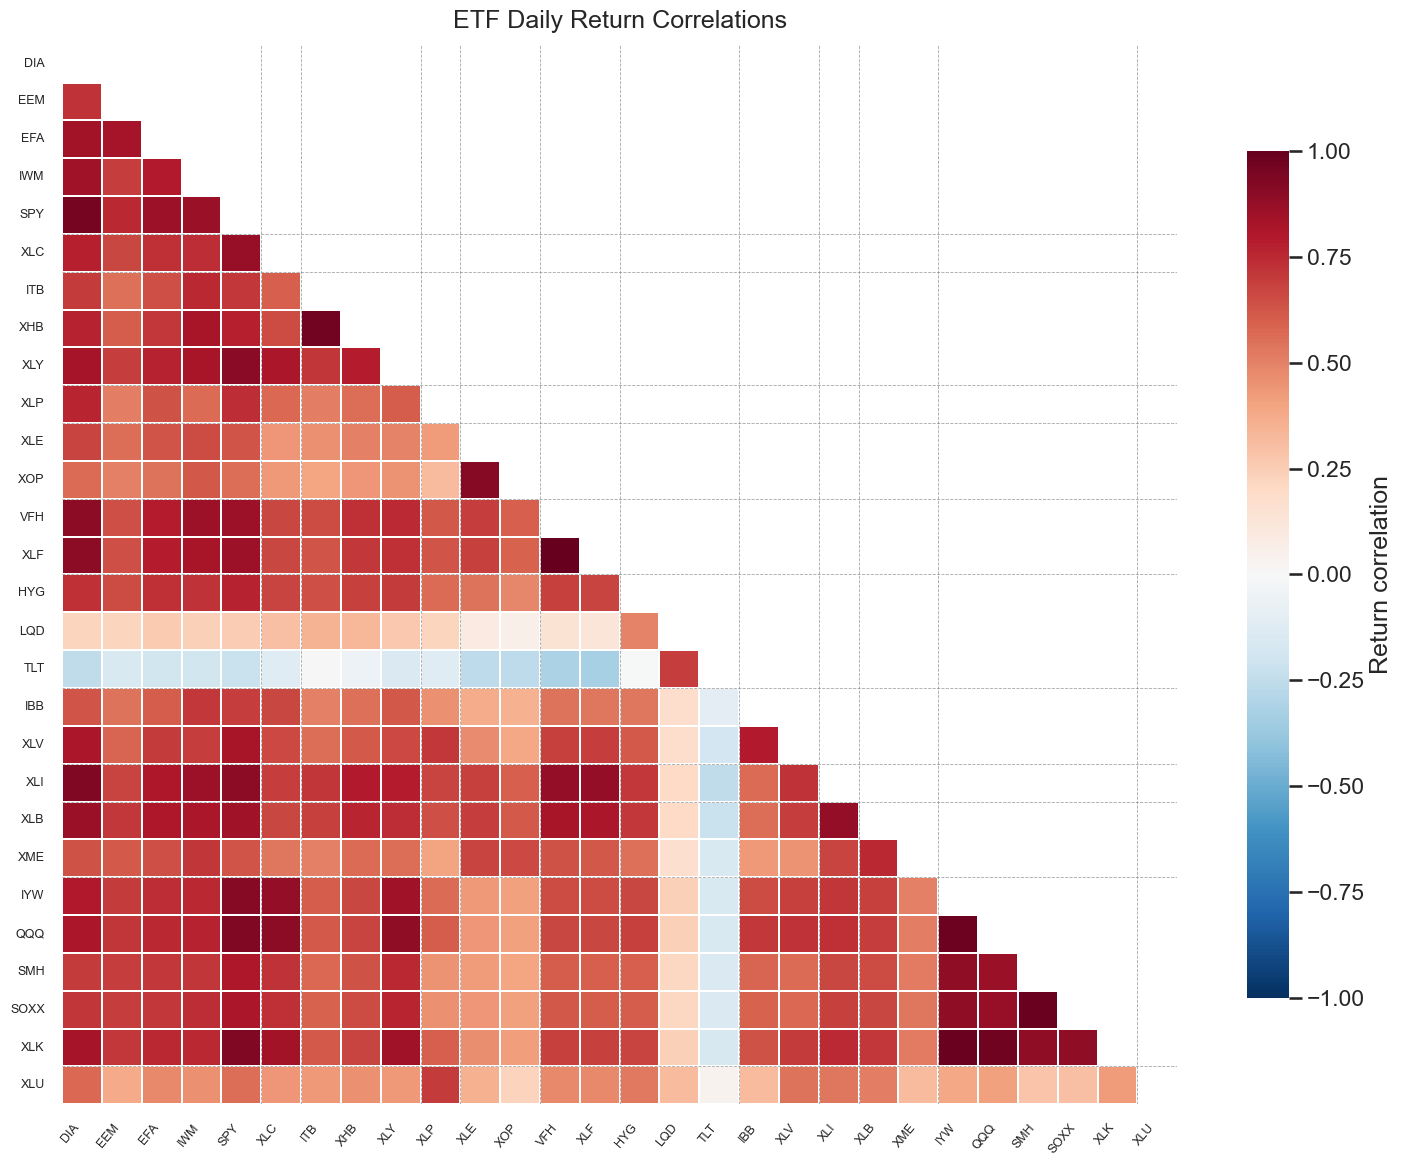

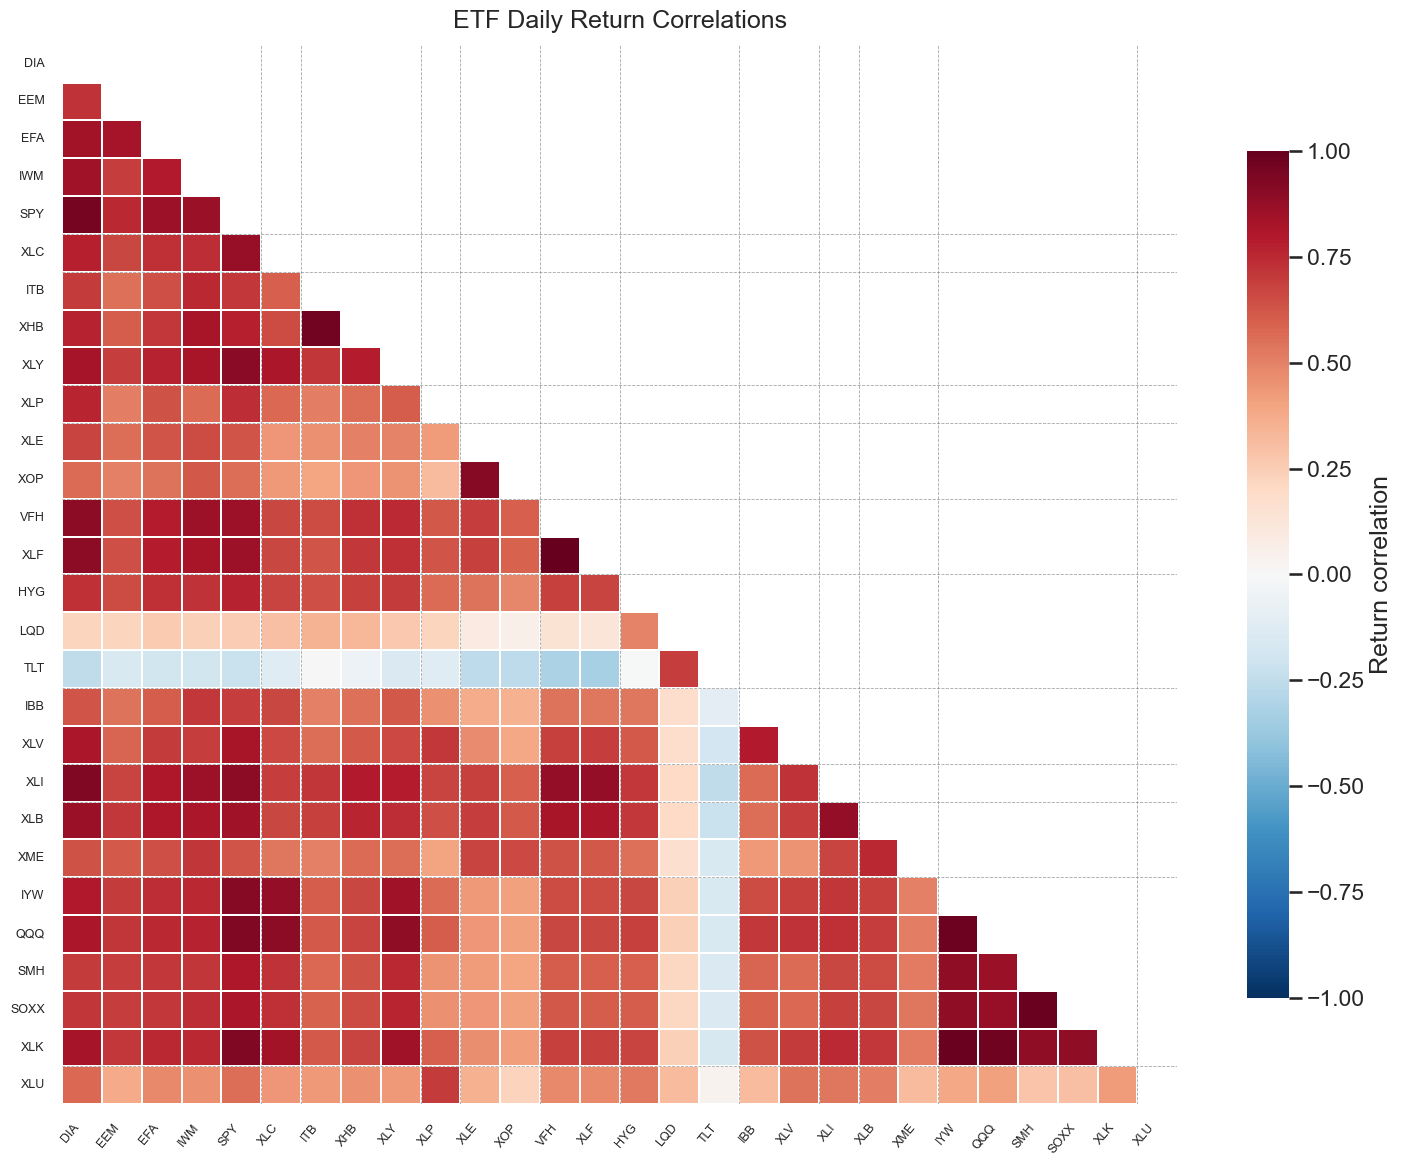

In [ ]:
heatmap_fig = plot_correlation_heatmap(
    corr_matrix,
    lower_triangle=True,
    mask_diagonal=False,
    annot=True,
    figsize=(15, 12),
    output_path=HEATMAP_PATH,
    cmap="RdBu_r",
    metadata=metadata_df,
)
print(f"Saved correlation heatmap to {HEATMAP_PATH}")
heatmap_fig


Saved clustermap to i:\Winter-Break-Research\results\figures\week1\week1_corr_clustermap.png


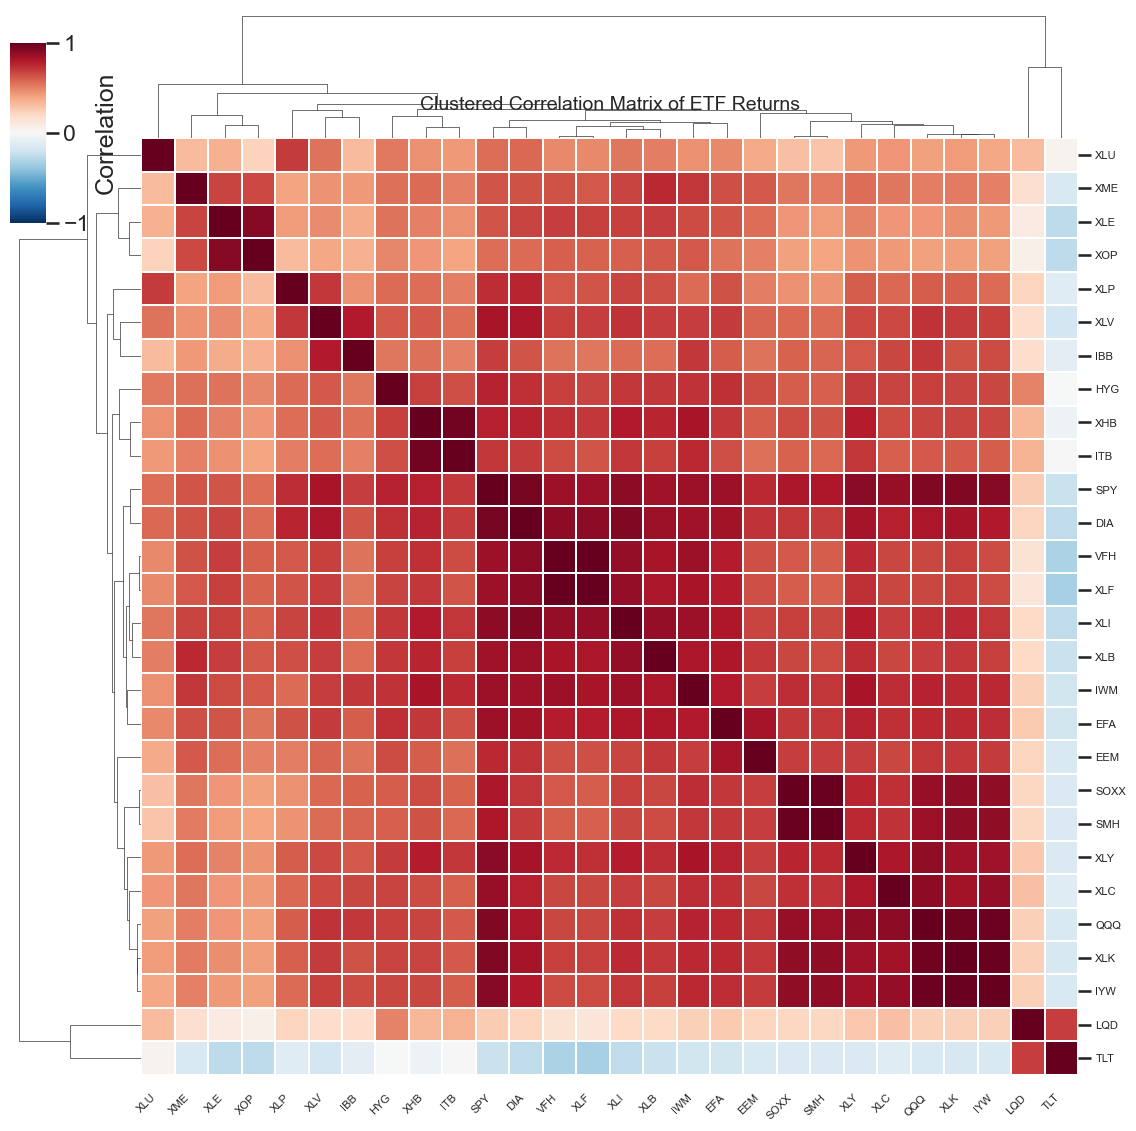

In [9]:
cluster_grid = plot_correlation_clustermap(
    corr_matrix,
    output_path=CLUSTER_PATH,
)
print(f"Saved clustermap to {CLUSTER_PATH}")
cluster_grid


In [10]:
base_corr_threshold = pair_defaults.get("min_corr", 0.85)
backoff_steps = (0.0, 0.02, 0.05, 0.08, 0.12, 0.15)
corr_trials = []
high_corr_pairs = pd.DataFrame()
selected_threshold = None

for step in backoff_steps:
    trial_threshold = round(max(base_corr_threshold - step, 0.7), 3)
    if corr_trials and abs(trial_threshold - corr_trials[-1]["threshold"]) < 1e-6:
        continue
    trial_df = find_high_corr_pairs(corr_matrix, threshold=trial_threshold)
    corr_trials.append({"threshold": trial_threshold, "pair_count": len(trial_df)})
    if not trial_df.empty:
        high_corr_pairs = trial_df.assign(corr_threshold_used=trial_threshold)
        selected_threshold = trial_threshold
        break

attempt_log = pd.DataFrame(corr_trials)
print("High-correlation pair search attempts:")
display(attempt_log)

if high_corr_pairs.empty:
    print(
        "No correlation pairs cleared the adaptive thresholds; consider expanding the lookback window or lowering min_corr further.",
    )
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    high_corr_pairs = attach_sector_labels(high_corr_pairs, metadata_source)
    high_corr_pairs.to_csv(HIGH_CORR_PATH, index=False)
    print(
        f"Full high-correlation pair table saved to {HIGH_CORR_PATH} using threshold {selected_threshold:.2f}",
    )
    display(high_corr_pairs.sort_values("correlation", ascending=False).head(10))

High-correlation pair search attempts:


,threshold,pair_count
0,0.85,36


Full high-correlation pair table saved to i:\Winter-Break-Research\results\week1_high_corr_pairs.csv using threshold 0.85


,leg_x,leg_y,correlation,corr_threshold_used,sector_x,sector_y,pair_bucket
22,VFH,XLF,0.993432,0.85,Financials,Financials,Same Sector
35,SOXX,SMH,0.989518,0.85,Technology,Technology,Same Sector
30,XLK,IYW,0.987665,0.85,Technology,Technology,Same Sector
27,QQQ,IYW,0.983171,0.85,Technology,Technology,Same Sector
26,QQQ,XLK,0.973701,0.85,Technology,Technology,Same Sector
20,XHB,ITB,0.962823,0.85,Consumer Discretionary,Consumer Discretionary,Same Sector
0,SPY,DIA,0.954206,0.85,Broad Market,Broad Market,Same Sector
13,DIA,XLI,0.929358,0.85,Broad Market,Industrials,Cross Sector
8,SPY,QQQ,0.929155,0.85,Broad Market,Technology,Cross Sector
9,SPY,XLK,0.928009,0.85,Broad Market,Technology,Cross Sector


In [11]:
def run_pair_scan_with_backoff(
    cfg: PairScanConfig,
    *,
    corr_thresholds: list[float] | None = None,
 ) -> tuple[pd.DataFrame, list[dict[str, float]]]:
    """Run the pair scan across a list of correlation thresholds until we get results."""
    thresholds = corr_thresholds or [cfg.min_corr]
    attempt_log: list[dict[str, float]] = []
    for thr in thresholds:
        trial_cfg = replace(cfg, min_corr=thr)
        trial_df = run_pair_scan(trial_cfg)
        attempt_log.append({"min_corr": thr, "pair_count": len(trial_df)})
        if not trial_df.empty:
            trial_df = trial_df.copy()
            trial_df["min_corr_used"] = thr
            return trial_df, attempt_log
    return pd.DataFrame(), attempt_log

In [12]:
pair_cfg_kwargs = {
    "config_path": CONFIG_PATH,
    "price_path": PRICE_PATH,
    "output_path": RESULTS_PATH,
    "list_name": LIST_OVERRIDE,
    "metadata_path": METADATA_PATH,
    "lookback_days": pair_defaults.get("lookback_days", 252),
    "min_obs": pair_defaults.get("min_obs", 150),
    "min_corr": pair_defaults.get("min_corr", 0.85),
    "max_pairs": pair_defaults.get("max_pairs", 50),
    "engle_granger_maxlag": pair_defaults.get("engle_granger_maxlag", 1),
    "return_method": pair_defaults.get("return_method", "log"),
}
if "allow_cross_sector" in inspect.signature(PairScanConfig).parameters:
    pair_cfg_kwargs["allow_cross_sector"] = ALLOW_CROSS_SECTOR

pair_scan_cfg = PairScanConfig(**pair_cfg_kwargs)

corr_backoff = []
for step in (0.0, 0.02, 0.04, 0.07, 0.1, 0.12, 0.15):
    candidate = round(max(pair_scan_cfg.min_corr - step, 0.7), 3)
    if not corr_backoff or candidate != corr_backoff[-1]:
        corr_backoff.append(candidate)

pair_scores, scan_attempts = run_pair_scan_with_backoff(
    pair_scan_cfg, corr_thresholds=corr_backoff
 )
print("Pair-scan attempts by min_corr:")
display(pd.DataFrame(scan_attempts))

if pair_scores.empty:
    print("No pairs met the scan criteria even after backoff; inspect coverage stats or relax parameters further.")
else:
    pair_scores.to_csv(RESULTS_PATH, index=False)
    print(f"Scored {len(pair_scores)} pairs using min_corr >= {pair_scores['min_corr_used'].iloc[0]:.2f}.")
    print(
        f"Pair score snapshot saved to {RESULTS_PATH} (cross-sector allowed: {ALLOW_CROSS_SECTOR})",
    )
    display(pair_scores.head())

Pair-scan attempts by min_corr:


,min_corr,pair_count
0,0.85,17


Scored 17 pairs using min_corr >= 0.85.
Pair score snapshot saved to i:\Winter-Break-Research\results\week1_pair_scores.csv (cross-sector allowed: True)


,universe,leg_x,leg_y,correlation,n_obs,spread_mean,spread_std,hedge_ratio,coint_statistic,coint_pvalue,half_life,min_corr_used
0,core_sectors,IYW,QQQ,0.975977,251,-23.701377,1.030433,0.361718,-3.435412,0.038567,4566.528602,0.85
1,core_sectors,XLK,IYW,0.982243,251,47.708427,1.884293,1.165181,-3.076174,0.093189,3867.770476,0.85
2,core_sectors,XLK,SPY,0.901637,251,27.374243,4.789981,0.351427,-3.070399,0.094404,505.316083,0.85
3,core_sectors,XLK,QQQ,0.964501,251,20.801678,2.531457,0.419930,-3.018298,0.105920,538.205907,0.85
4,core_sectors,XLF,VFH,0.985795,251,2.139440,0.169182,0.391577,-2.909433,0.133332,NaN,0.85


In [13]:
if pair_scores.empty:
    print("No qualifying pairs found; adjust thresholds and rerun.")
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    pair_scores = attach_sector_labels(pair_scores, metadata_source)

    corr_summary = summarise_pairs_by_bucket(pair_scores)
    display(corr_summary)
    corr_path = RESULTS_PATH.parent / "week1_pair_corr_summary.csv"
    corr_summary.to_csv(corr_path)
    print(f"Correlation summary saved to {corr_path}")

    pvalue_summary = (
        pair_scores.groupby("pair_bucket")["coint_pvalue"].agg(["mean", "median"]).round(4)
    )
    display(pvalue_summary)
    pval_path = RESULTS_PATH.parent / "week1_pair_pvalues_summary.csv"
    pvalue_summary.to_csv(pval_path)
    print(f"Engle–Granger p-value summary saved to {pval_path}")


,n_pairs,mean,min,max
pair_bucket,,,,
Cross Sector,3,0.919,0.902,0.945
Same Sector,14,0.935,0.883,0.986


Correlation summary saved to i:\Winter-Break-Research\results\week1_pair_corr_summary.csv


,mean,median
pair_bucket,,
Cross Sector,0.2570,0.2498
Same Sector,0.6528,0.8362


Engle–Granger p-value summary saved to i:\Winter-Break-Research\results\week1_pair_pvalues_summary.csv


Saved count plot to i:\Winter-Break-Research\results\figures\week1\week1_pair_bucket_counts.png


i:\Winter-Break-Research\src\pairs_trading_etf\analysis\correlation.py:269: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_df, x="pair_bucket", y="pairs", palette="viridis", ax=ax)


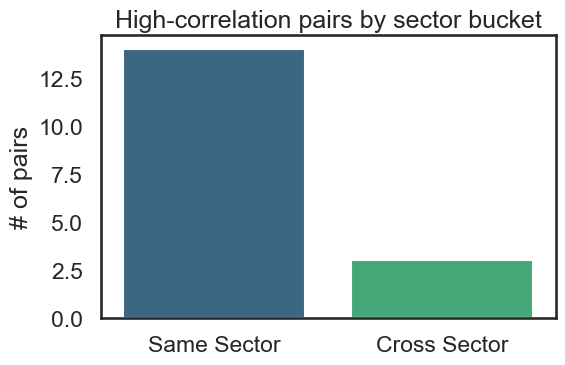

In [14]:
if pair_scores.empty:
    print("Skipping count plot because no pairs were scored.")
else:
    count_fig = plot_pair_bucket_counts(pair_scores, output_path=PAIR_COUNTS_PATH)
    print(f"Saved count plot to {PAIR_COUNTS_PATH}")
    count_fig


i:\Winter-Break-Research\src\pairs_trading_etf\analysis\correlation.py:290: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pairs_df, x="pair_bucket", y="correlation", palette="pastel", ax=ax)


Saved correlation boxplot to i:\Winter-Break-Research\results\figures\week1\week1_pair_corr_box.png


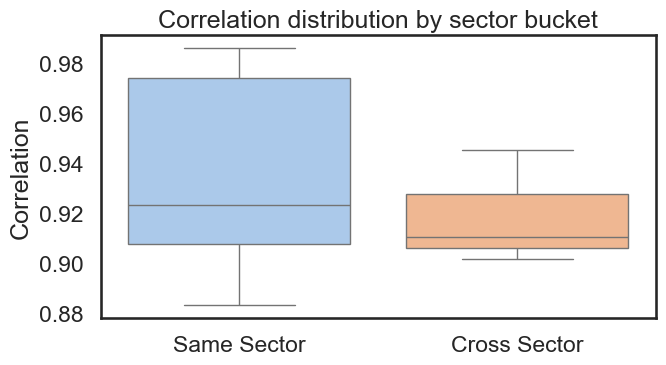

In [15]:
if pair_scores.empty:
    print("Skipping boxplot because no pairs were scored.")
else:
    box_fig = plot_pair_bucket_boxplot(pair_scores, output_path=PAIR_BOX_PATH)
    print(f"Saved correlation boxplot to {PAIR_BOX_PATH}")
    box_fig


Saved scatter plot to i:\Winter-Break-Research\results\figures\week1\week1_corr_vs_pvalue.png


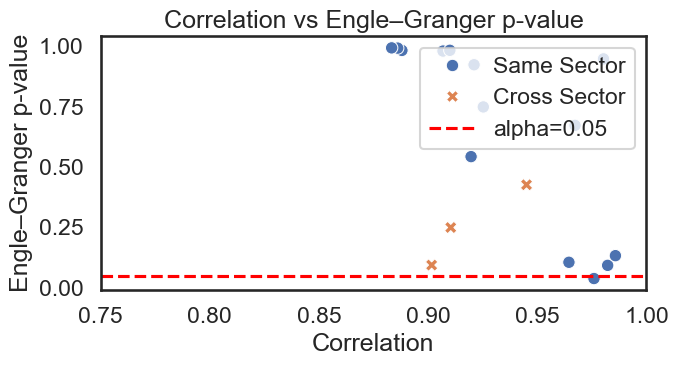

In [16]:
if pair_scores.empty:
    print("Skipping scatter plot because no pairs were scored.")
else:
    try:
        scatter_fig = plot_corr_vs_pvalue(pair_scores, output_path=SCATTER_PATH)
    except ValueError as exc:
        print(f"Skipping scatter plot: {exc}")
    else:
        print(f"Saved scatter plot to {SCATTER_PATH}")
        scatter_fig


In [17]:
if pair_scores.empty:
    print("Skipping Johansen test because no pairs were scored.")
else:
    top_pairs = pair_scores.sort_values("correlation", ascending=False).head(3)
    candidate = []
    for _, row in top_pairs.iterrows():
        for leg in (row["leg_x"], row["leg_y"]):
            if leg not in candidate:
                candidate.append(leg)
        if len(candidate) >= 3:
            break

    if len(candidate) < 3:
        print(
            "Need at least three unique tickers from the scored pairs to run the Johansen test."
        )
    else:
        price_frame = build_price_frame(
            PRICE_PATH, tickers=candidate, min_non_na=150, return_method="log"
        )
        levels = price_frame.prices[candidate].dropna()
        log_levels = np.log(levels.where(levels > 0)).dropna()

        johansen_res = coint_johansen(log_levels, det_order=0, k_ar_diff=1)
        trace_df = pd.DataFrame(
            {
                "trace_stat": johansen_res.lr1,
                "crit_90": johansen_res.cvt[:, 0],
                "crit_95": johansen_res.cvt[:, 1],
                "crit_99": johansen_res.cvt[:, 2],
            },
            index=[f"r <= {i}" for i in range(len(johansen_res.lr1))],
        )

        print(f"Johansen trace test for candidate set: {', '.join(candidate[:3])}")
        display(trace_df.round(3))
        trace_df.to_csv(JOHANSEN_PATH)
        print(f"Johansen trace table saved to {JOHANSEN_PATH}")

Johansen trace test for candidate set: XLF, VFH, XLK


,trace_stat,crit_90,crit_95,crit_99
r <= 0,38.492,44.493,47.854,54.682
r <= 1,15.255,27.067,29.796,35.463
r <= 2,4.228,13.429,15.494,19.935
r <= 3,0.592,2.706,3.842,6.635


Johansen trace table saved to i:\Winter-Break-Research\results\week1_johansen_trace.csv


## Week 1 pair-scan outputs
- `results/week1_pair_scores.csv` is overwritten on each run with the latest ranked pairs.
- `results/week1_pair_corr_summary.csv` and `results/week1_pair_pvalues_summary.csv` capture the bucketed stats for downstream reporting.
- Static figures (`results/figures/week1/*.png`) include the pair-bucket count bar, correlation boxplot, and correlation vs Engle–Granger scatter to drop into advisor decks.
- `results/week1_johansen_trace.csv` stores the Johansen trace table for the top trio, aligning with the Track C deliverables.
- Re-run the notebook whenever `configs/data.yaml` changes to regenerate all artifacts with the updated universe.